In [ ]:
import numpy
import pandas as pd
from google.colab import drive
import os
import warnings
import seaborn as sns
import matplotlib.pylab as plt
import PIL
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_curve, auc

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Create Dataset 

In [ ]:
warnings.filterwarnings('ignore')
image_size = 224
application = Xception
batch_size = 60

In [ ]:
train_list_filenames=[]
train_list_labels=[]
dstpath='gdrive/My Drive/Proyect Final Vision/train'
test_df = pd.read_csv('gdrive/My Drive/Proyect Final Vision/test.txt', sep=" ", header=None)
test_df.columns=['patient id', 'filenames', 'labels', 'data source' ]
test_df=test_df.drop(['patient id', 'data source'], axis=1 )
print (test_df.head())
train_txt= open("gdrive/My Drive/Proyect Final Vision/train.txt","r")
train_list=train_txt.readlines()
for line in train_list:
    split=line.split(' ')    
    if len(split)>4:        
        fname=os.path.join(dstpath, split[2])        
        label=split [3]
    else:        
        fname=os.path.join(dstpath, split[1])
        label=split[2]
    train_list_filenames.append(fname)
    train_list_labels.append(label)
Ftrseries=pd.Series(train_list_filenames, name='filenames')
Ltrseries=pd.Series(train_list_labels, name='labels')
df=pd.concat([Ftrseries, Ltrseries], axis=1)
print (df.head())
balance=df['labels'].value_counts()
print (balance)

                                   filenames    labels
0  MIDRC-RICORD-1C-419639-003251-46647-0.png  positive
1  MIDRC-RICORD-1C-419639-001464-39871-0.png  positive
2  MIDRC-RICORD-1C-419639-000918-78965-0.png  positive
3  MIDRC-RICORD-1C-419639-003318-64285-0.png  positive
4  MIDRC-RICORD-1C-419639-001015-81591-0.png  positive
                                           filenames    labels
0  gdrive/My Drive/Proyect Final Vision/train/ARD...  negative
1  gdrive/My Drive/Proyect Final Vision/train/acu...  negative
2  gdrive/My Drive/Proyect Final Vision/train/acu...  negative
3  gdrive/My Drive/Proyect Final Vision/train/ard...  negative
4  gdrive/My Drive/Proyect Final Vision/train/pne...  negative
negative    13793
positive     2158
Name: labels, dtype: int64


In [ ]:
file_count = 2158
samples = []
for category in df['labels'].unique():    
    category_slice = df.query("labels == @category")    
    samples.append(category_slice.sample(file_count, replace=False,random_state=1))
df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print (  df['labels'].value_counts())
print (len(df))

positive    2158
negative    2158
Name: labels, dtype: int64
4316


In [ ]:
tsplit=.9
train_df, valid_df=train_test_split(df, train_size=tsplit, shuffle=True, random_state=123)

# Create Generators

In [ ]:
def scalar(img):
    return img/127.5-1

In [ ]:
gen=ImageDataGenerator(preprocessing_function=scalar)

In [ ]:
train_gen=gen.flow_from_dataframe( train_df, x_col='filenames', y_col='labels', target_size=(224, 224), class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=60)

In [ ]:
valid_gen=gen.flow_from_dataframe( valid_df, x_col='filenames', y_col='labels', target_size=(224, 224), class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=60)

Found 432 validated image filenames belonging to 2 classes.


# Define steps

In [ ]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 2
    else:
        return num_samples // batch_size

In [ ]:
nb_train_sample = train_df.shape[0] * 0.9
nb_validation_sample = train_df.shape[0] - nb_train_sample
nb_test_sample = valid_df.shape[0]
print(nb_train_sample)
print(nb_validation_sample)
print(nb_test_sample)

3495.6
388.4000000000001
432


# Define the model

In [ ]:
def get_model():
    base_model = application(weights='imagenet', input_shape=(image_size,image_size,3), include_top=False)
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='softmax'))
    model.summary()
    optimizer = optimizers.RMSprop(lr=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

    return model

In [ ]:
model = get_model()

83697664/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 21,386,538
Trainable params: 21,332,010
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
model_path = 'gdrive/My Drive/Proyect Final Vision/model/'
if not os.path.exists(model_path):
    os.mkdir(model_path)
    
model_path = model_path + 'xception-model.hdf5'

In [ ]:
patient = 2
callbacks1 = [
    EarlyStopping(monitor='val_loss', patience=patient, mode='min', verbose=1),
    ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = patient / 2, min_lr=0.001, verbose=1, mode='min'),
    ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min'),
    ]

# Fit the model

In [ ]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=get_steps(nb_train_sample, batch_size),
    epochs=10,
    validation_data=valid_gen,
    validation_steps=get_steps(nb_validation_sample, batch_size),
    verbose=1,
    callbacks = callbacks1
)

# Confusion matrix

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(error_list[i], pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    
    if len(classes)<= 30:
        # create a confusion matrix and a test report        
        y_true= np.array(labels)        
        y_pred=np.array(y_pred)        
        cm = confusion_matrix(y_true, y_pred )
        clr = classification_report(y_true, y_pred, target_names=classes)
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()    
        print("Classification Report:\n----------------------\n", clr)

In [ ]:
print_code=0
preds=model.predict(valid_gen, batch_size=60, steps=get_steps(nb_validation_sample, 60), verbose=1) 
print_info( valid_gen, preds, print_code, 'gdrive/My Drive/Proyect Final Vision/model/', 'covid' )

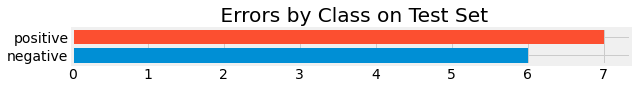

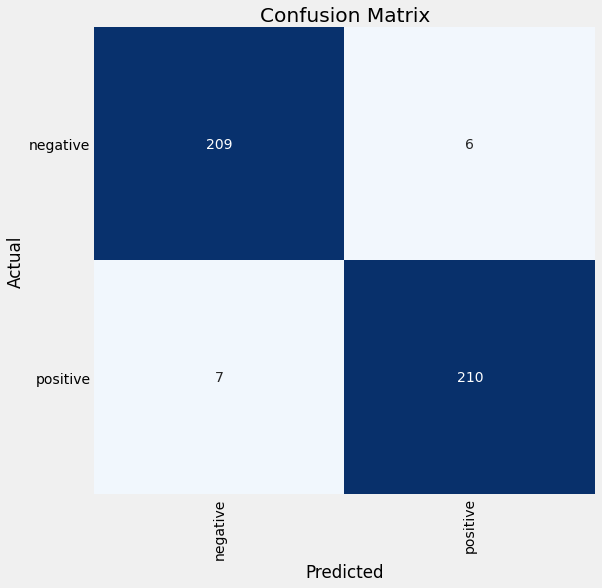

Classification Report:
----------------------
               precision    recall  f1-score   support

    negative       0.97      0.97      0.97       215
    positive       0.97      0.97      0.97       217

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432



In [ ]:
print_info( valid_gen, preds, print_code, 'gdrive/My Drive/Proyect Final Vision/model/', 'covid' )

# Roc curve

In [ ]:
valid_gen.reset()
preds = loaded_model.predict(valid_gen)[:,1]

In [ ]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(valid_gen.classes, preds)
auc_rf = auc(fpr_rf, tpr_rf)

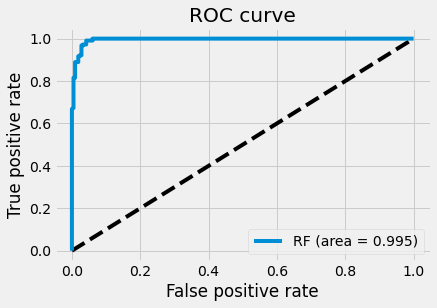

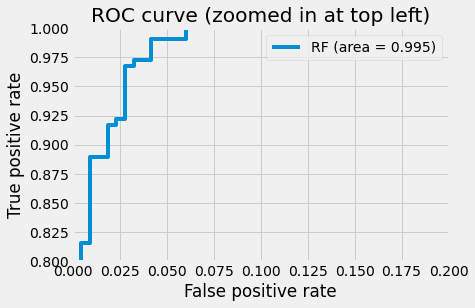

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()